In [ ]:
import tensorflow as tf
import numpy as np
import os
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import color
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 3


training_images_names = os.listdir('data/Training_Images/')
training_masks_names = os.listdir('data/masks/')

X = np.zeros((len(training_images_names),IMG_HEIGHT,IMG_WIDTH,CHANNELS),dtype='uint8')
y = np.zeros((len(training_masks_names),IMG_HEIGHT,IMG_WIDTH,1))

In [ ]:
for i,n in enumerate(training_images_names):
    img = imread(f'data/Training_Images/{n}')
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH,CHANNELS),mode='constant',preserve_range=True)
    fn = str(n.split('.')[0]) + '.png'
    mask = imread(f'data/masks/{fn}')
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH,1),mode='constant')

    X[i] = img
    y[i] = mask

X[0].shape

(256, 256, 3)

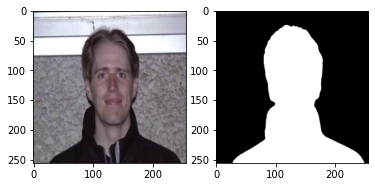

In [ ]:
i = np.random.randint(0,len(X))
fig,(a1,a2)=plt.subplots(1,2)
a1.imshow(X[i])
a2.imshow(y[i].reshape(y[i].shape[:-1]),cmap='gray')

In [ ]:
#building U-Net

inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

#contracting path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)


c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5_1 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5_1 = tf.keras.layers.Dropout(0.3)(c5_1)
c5_2 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5_1)
c5_3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_2)
c5_4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_3 )
c5_5 = tf.keras.layers.concatenate([c5_1,c5_4])


#expanding path
u4 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5_5)
u4 = tf.keras.layers.concatenate([u4,c4])
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u3 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(u4)
u3 = tf.keras.layers.concatenate([u3,c3])
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)


u2 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(u3)
u2 = tf.keras.layers.concatenate([u2,c2])
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)


u1 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1,c1])
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

output = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(u1)

model = tf.keras.Model(inputs=[inputs],outputs=[output])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.1, random_state=42)

In [ ]:
# TRAINING MODEL

results = model.fit(X_train,y_train,batch_size=16,epochs=100)
model.save('models/human_segmentation_non-aug_100_v2.h5')

Epoch 1/100
17/17 [==============================] - 21s 462ms/step - loss: 0.6017 - accuracy: 0.6831
Epoch 2/100
17/17 [==============================] - 5s 305ms/step - loss: 0.5699 - accuracy: 0.7010
Epoch 3/100
17/17 [==============================] - 5s 305ms/step - loss: 0.5337 - accuracy: 0.6873
Epoch 4/100
17/17 [==============================] - 5s 305ms/step - loss: 0.5679 - accuracy: 0.7010
Epoch 5/100
17/17 [==============================] - 5s 305ms/step - loss: 0.5187 - accuracy: 0.7010
Epoch 6/100
17/17 [==============================] - 5s 306ms/step - loss: 0.4854 - accuracy: 0.7026
Epoch 7/100
17/17 [==============================] - 5s 306ms/step - loss: 0.4962 - accuracy: 0.6786
Epoch 8/100
17/17 [==============================] - 5s 306ms/step - loss: 0.4561 - accuracy: 0.6791
Epoch 9/100
17/17 [==============================] - 5s 306ms/step - loss: 0.4360 - accuracy: 0.7025
Epoch 10/100
17/17 [==============================] - 5s 306ms/step - loss: 0.4419 - accur

17/17 [==============================] - 5s 309ms/step - loss: 0.0414 - accuracy: 0.8270
Epoch 82/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0410 - accuracy: 0.8273
Epoch 83/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0403 - accuracy: 0.8274
Epoch 84/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0416 - accuracy: 0.8270
Epoch 85/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0396 - accuracy: 0.8276
Epoch 86/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0372 - accuracy: 0.8281
Epoch 87/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0360 - accuracy: 0.8285
Epoch 88/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0376 - accuracy: 0.8280
Epoch 89/100
17/17 [==============================] - 5s 310ms/step - loss: 0.0374 - accuracy: 0.8281
Epoch 90/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0367 - accuracy: 

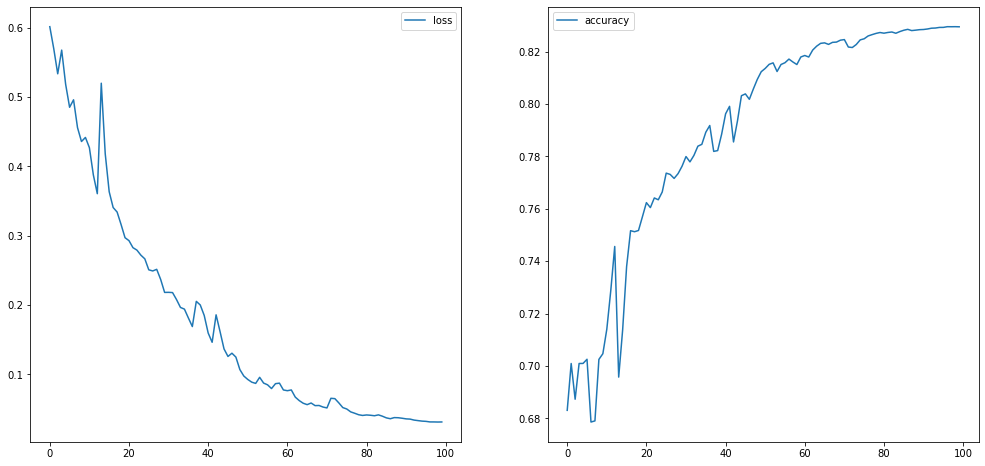

In [ ]:
fig,(a1,a2) = plt.subplots(1,2,figsize=(17,8))
a1.plot(np.arange(0,100),results.history['loss'],label = 'loss')
a2.plot(np.arange(0,100),results.history['accuracy'],label='accuracy')
a1.legend()
a2.legend()
plt.savefig('losses_and_accuracies_100_v2.png')

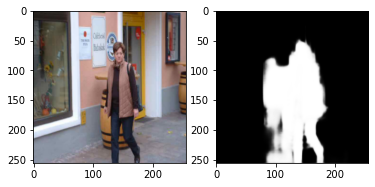

In [ ]:
k=np.random.randint(0,len(X_test))
fig,(a1,a2) = plt.subplots(1,2)

a1.imshow(X_test[k])

(h,w,c) = X_test[k].shape
i = X_test[k].reshape((1,h,w,c))

pred = model.predict(i)

a2.imshow(pred.reshape(pred.shape[1:-1]),cmap='gray')